In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import binarize
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [49]:
class HopfieldNetwork:
    
    def __init__(self, size):
        self.size = size
        self.weights = np.zeros((size, size))
        self.patterns = []
        
    def train(self, patterns):
        patterns = np.array(patterns)
        self.patterns = patterns.copy()
        
        self.weights = np.zeros((self.size, self.size))
        
        for pattern in patterns:
            self.weights += np.outer(pattern, pattern)
        
        self.weights /= len(patterns)
        
        np.fill_diagonal(self.weights, 0)
        
    def energy(self, state):
        return -0.5 * np.dot(state, np.dot(self.weights, state))
    
    def update_async(self, state, max_iter=100, random_order=True):
        state = np.array(state, dtype=float)
        energy_history = [self.energy(state)]
        
        for iteration in range(max_iter):
            prev_state = state.copy()
            
            if random_order:
                indices = np.random.permutation(self.size)
            else:
                indices = range(self.size)
            
            for i in indices:
                net_input = np.dot(self.weights[i], state)
                state[i] = 1 if net_input > 0 else -1
            
            energy_history.append(self.energy(state))
            
            if np.array_equal(state, prev_state):
                return state, energy_history, True
                
        return state, energy_history, False
    
    def update_sync(self, state, max_iter=100):
        state = np.array(state, dtype=float)
        energy_history = [self.energy(state)]
        
        for iteration in range(max_iter):
            prev_state = state.copy()
            
            net_input = np.dot(self.weights, state)
            state = np.where(net_input > 0, 1, -1)
            
            energy_history.append(self.energy(state))
            
            if np.array_equal(state, prev_state):
                return state, energy_history, True
                
        return state, energy_history, False
    
    def recall(self, corrupted_pattern, method='async', **kwargs):
        if method == 'async':
            return self.update_async(corrupted_pattern, **kwargs)
        else:
            return self.update_sync(corrupted_pattern, **kwargs)

In [50]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X, y = mnist.data[:1000], mnist.target[:1000].astype(int)

X_normalized = X / 255.0
X_binary = binarize(X_normalized, threshold=0.5) * 2 - 1 

print(f"Data size: {X_binary.shape}")
print(f"Value range: {X_binary.min()} - {X_binary.max()}")

Data size: (1000, 784)
Value range: -1.0 - 1.0


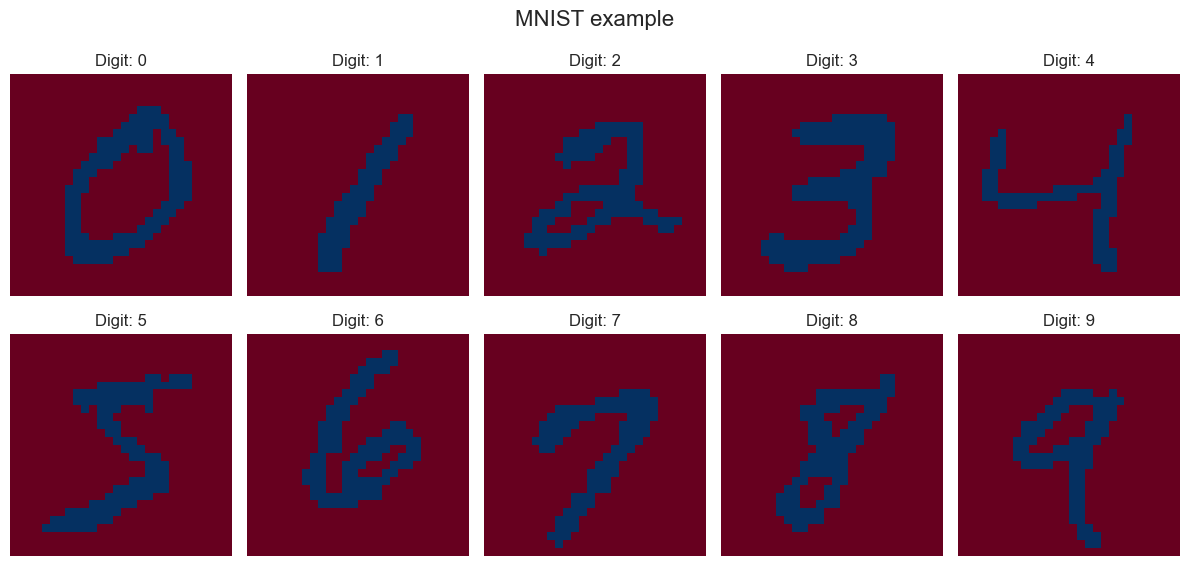

In [51]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('MNIST example', fontsize=16)

for i in range(10):
    idx = np.where(y == i)[0][0]
    ax = axes[i//5, i%5]
    ax.imshow(X_binary[idx].reshape(28, 28), cmap='RdBu', vmin=-1, vmax=1)
    ax.set_title(f'Digit: {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [52]:
n_patterns = 10
selected_patterns = []
pattern_labels = []

for digit in range(n_patterns):
    idx = np.where(y == digit)[0][0]
    selected_patterns.append(X_binary[idx])
    pattern_labels.append(digit)

selected_patterns = np.array(selected_patterns)

hopfield = HopfieldNetwork(784)
hopfield.train(selected_patterns)

In [56]:
def add_noise(pattern, noise_level=0.1):
    noisy_pattern = pattern.copy()
    n_flips = int(len(pattern) * noise_level)
    flip_indices = np.random.choice(len(pattern), n_flips, replace=False)
    noisy_pattern[flip_indices] *= -1
    return noisy_pattern

def visualize_recall(original, noisy, recalled, title=""):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(original.reshape(28, 28), cmap='RdBu', vmin=-1, vmax=1)
    axes[0].set_title('original')
    axes[0].axis('off')
    
    axes[1].imshow(noisy.reshape(28, 28), cmap='RdBu', vmin=-1, vmax=1)
    axes[1].set_title('with noise')
    axes[1].axis('off')
    
    axes[2].imshow(recalled.reshape(28, 28), cmap='RdBu', vmin=-1, vmax=1)
    axes[2].set_title('pattern')
    axes[2].axis('off')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

Noise level: 5.0%, Accuracy: 84.7%, converged: True


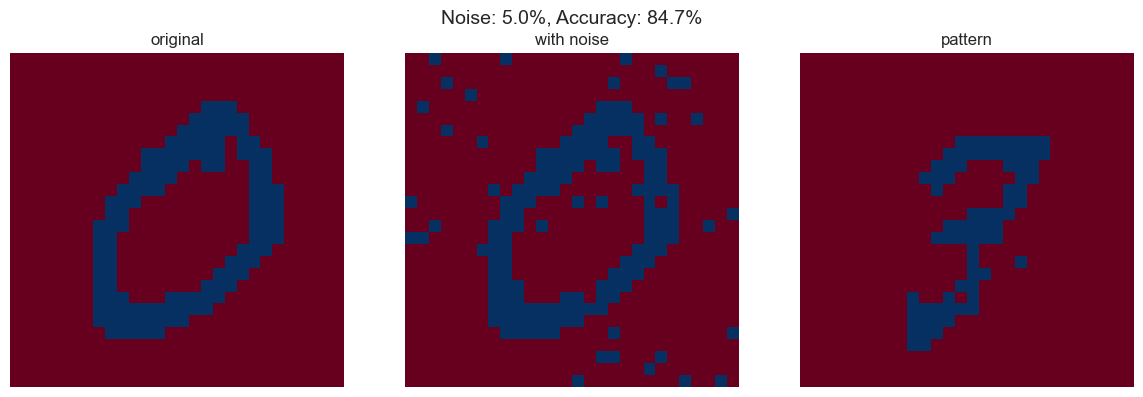

Noise level: 10.0%, Accuracy: 84.7%, converged: True


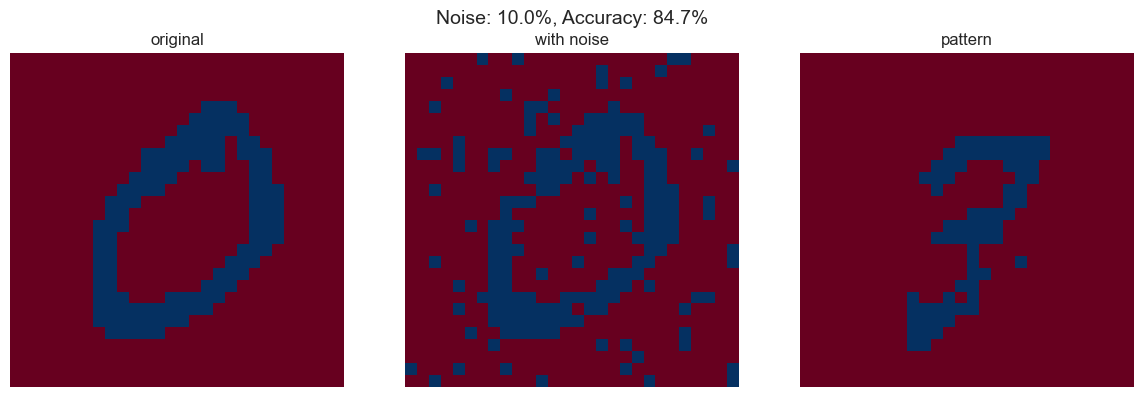

Noise level: 20.0%, Accuracy: 84.7%, converged: True


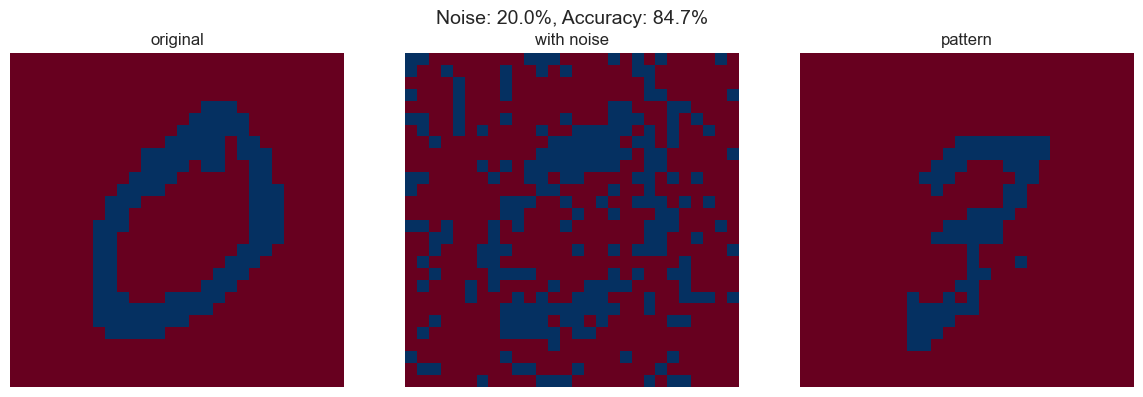

Noise level: 30.0%, Accuracy: 84.7%, converged: True


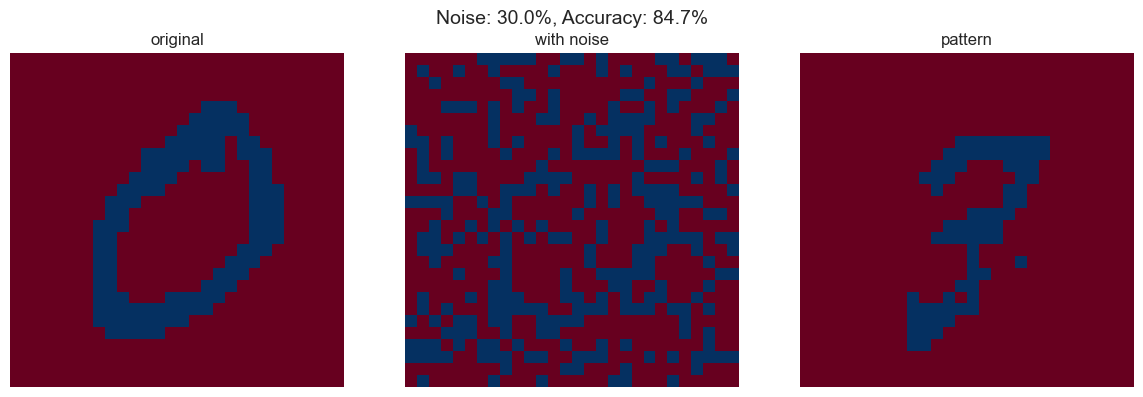

In [57]:
noise_levels = [0.05, 0.1, 0.2, 0.3]
pattern_idx = 0

for noise_level in noise_levels:
    noisy_pattern = add_noise(selected_patterns[pattern_idx], noise_level)
    
    recalled, energy_history, converged = hopfield.recall(noisy_pattern, method='async')
    
    accuracy = np.mean(recalled == selected_patterns[pattern_idx])
    
    print(f"Noise level: {noise_level:.1%}, Accuracy: {accuracy:.1%}, converged: {converged}")
    visualize_recall(
            selected_patterns[pattern_idx], 
            noisy_pattern, 
            recalled,
            f"Noise: {noise_level:.1%}, Accuracy: {accuracy:.1%}"
        )

In [64]:
def analyze_capacity(max_patterns=20):
    pattern_counts = range(1, min(max_patterns, 11))
    accuracies = []
    
    for n_patterns in tqdm(pattern_counts):
        test_patterns = []
        for i in range(n_patterns):
            idx = np.where(y == i)[0][0]
            test_patterns.append(X_binary[idx])
        
        test_patterns = np.array(test_patterns)
        
        test_network = HopfieldNetwork(784)
        test_network.train(test_patterns)
        
        total_accuracy = 0
        n_tests = 10
        
        for _ in range(n_tests):
            for pattern in test_patterns:
                noisy = add_noise(pattern, 0.1)
                recalled, _, _ = test_network.recall(noisy, method='async', max_iter=50)
                total_accuracy += np.mean(recalled == pattern)
        
        avg_accuracy = total_accuracy / (n_patterns * n_tests)
        accuracies.append(avg_accuracy)
    
    return pattern_counts, accuracies

100%|█████████████████████████████████████████████| 9/9 [00:03<00:00,  2.78it/s]


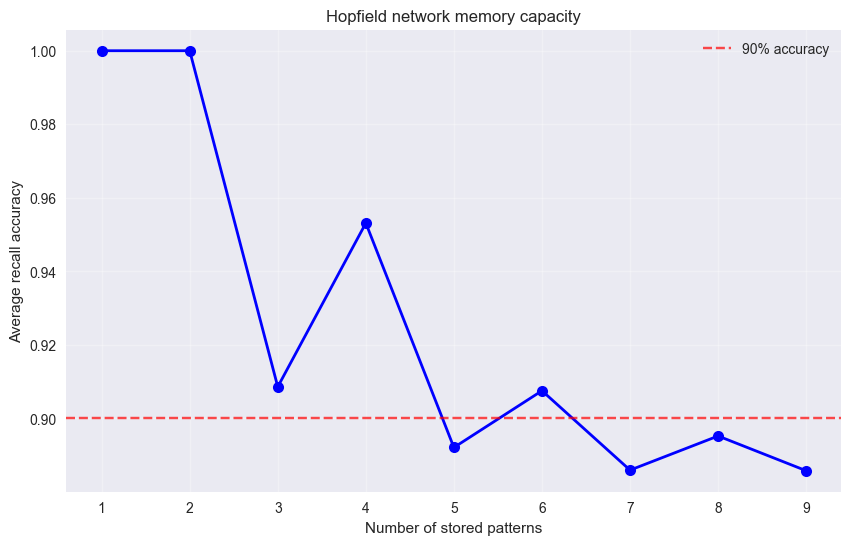

In [65]:
pattern_counts, accuracies = analyze_capacity(10)

plt.figure(figsize=(10, 6))
plt.plot(pattern_counts, accuracies, 'bo-', linewidth=2, markersize=8)
plt.axhline(y=0.9, color='r', linestyle='--', alpha=0.7, label='90% accuracy')
plt.xlabel('Number of stored patterns')
plt.ylabel('Average recall accuracy')
plt.title('Hopfield network memory capacity')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [66]:
theoretical_capacity = 0.138 * 784
print(f"Theoretical capacity: {theoretical_capacity:.0f} patterns")

Theoretical capacity: 108 patterns


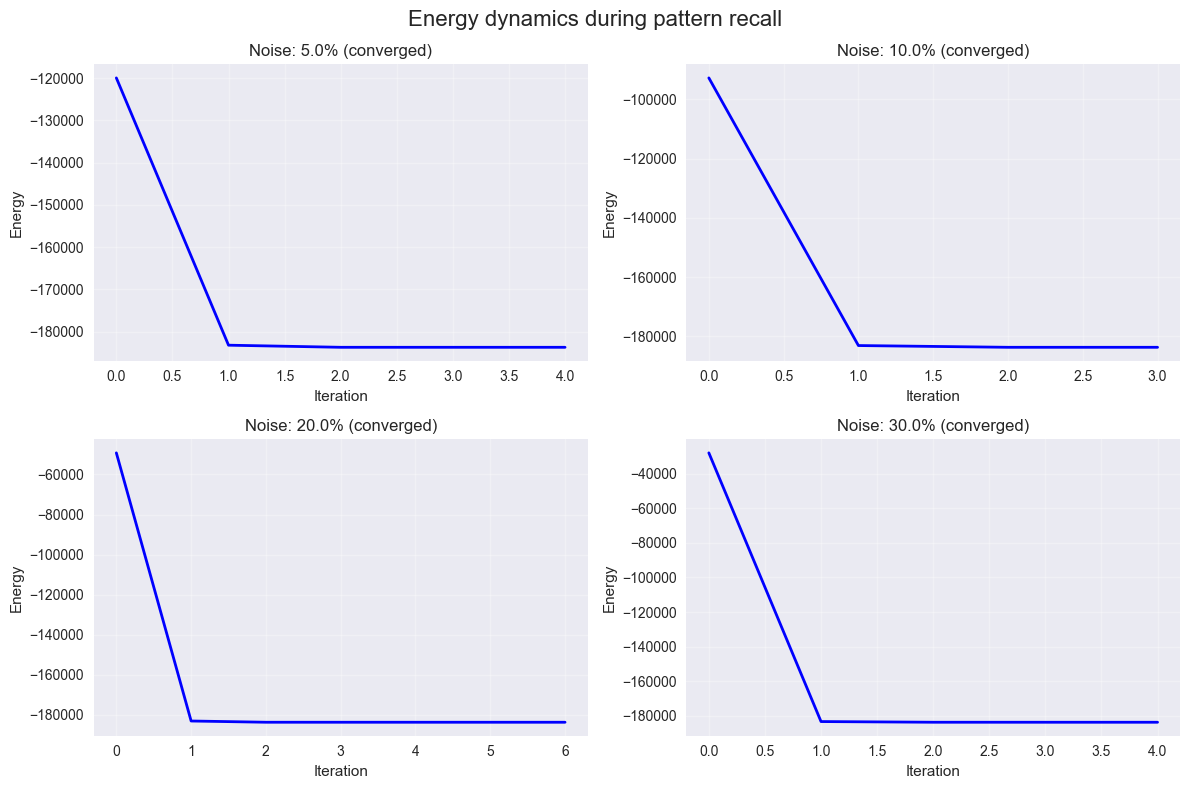

In [67]:
def analyze_energy_dynamics():
    pattern = selected_patterns[0]
    noise_levels = [0.05, 0.1, 0.2, 0.3]
    
    plt.figure(figsize=(12, 8))
    
    for i, noise_level in enumerate(noise_levels):
        plt.subplot(2, 2, i+1)
        
        noisy_pattern = add_noise(pattern, noise_level)
        recalled, energy_history, converged = hopfield.recall(
            noisy_pattern, method='async', max_iter=100
        )
        
        plt.plot(energy_history, 'b-', linewidth=2)
        plt.xlabel('Iteration')
        plt.ylabel('Energy')
        plt.title(f'Noise: {noise_level:.1%} ({"converged" if converged else "not converged"})')
        plt.grid(True, alpha=0.3)
        
    plt.suptitle('Energy dynamics during pattern recall', fontsize=16)
    plt.tight_layout()
    plt.show()

analyze_energy_dynamics()

Asynchronous update - Accuracy: 84.7%, Convergence: True
Synchronous update - Accuracy: 84.7%, Convergence: True


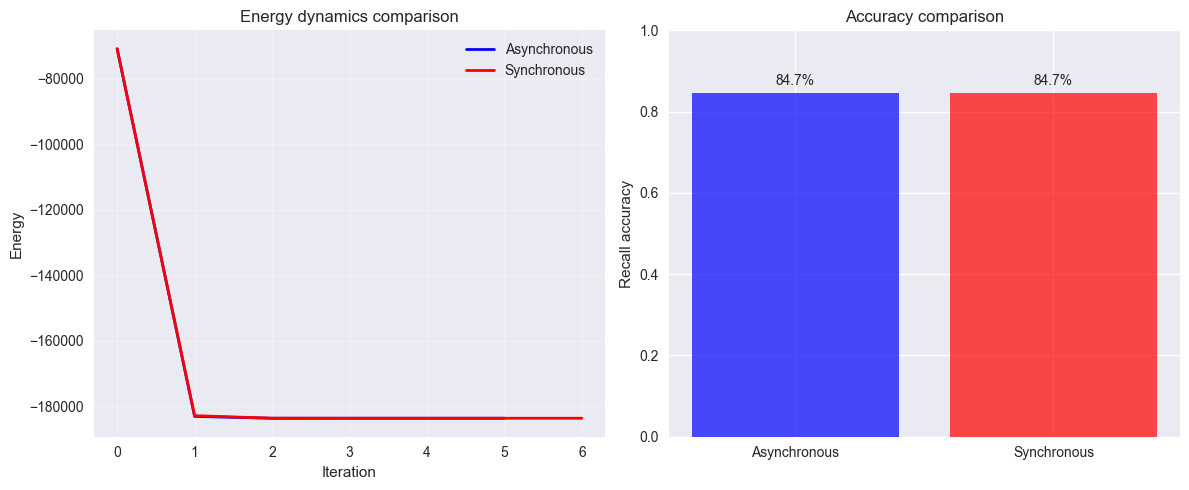

In [70]:
def compare_update_methods():
    pattern = selected_patterns[0]
    noisy_pattern = add_noise(pattern, 0.15)
    
    recalled_async, energy_async, conv_async = hopfield.recall(
        noisy_pattern, method='async', max_iter=100
    )
    
    recalled_sync, energy_sync, conv_sync = hopfield.recall(
        noisy_pattern, method='sync', max_iter=100
    )
    
    acc_async = np.mean(recalled_async == pattern)
    acc_sync = np.mean(recalled_sync == pattern)
    
    print(f"Asynchronous update - Accuracy: {acc_async:.1%}, Convergence: {conv_async}")
    print(f"Synchronous update - Accuracy: {acc_sync:.1%}, Convergence: {conv_sync}")
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(energy_async, 'b-', label='Asynchronous', linewidth=2)
    plt.plot(energy_sync, 'r-', label='Synchronous', linewidth=2)
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
    plt.title('Energy dynamics comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    methods = ['Asynchronous', 'Synchronous']
    accuracies = [acc_async, acc_sync]
    colors = ['blue', 'red']
    
    plt.bar(methods, accuracies, color=colors, alpha=0.7)
    plt.ylabel('Recall accuracy')
    plt.title('Accuracy comparison')
    plt.ylim(0, 1)
    
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.01, f'{acc:.1%}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

compare_update_methods()

In [71]:
def analyze_pattern_stability():    
    for i, pattern in enumerate(selected_patterns):
        stable_pattern, _, converged = hopfield.recall(pattern, method='async', max_iter=50)
        stability = np.mean(stable_pattern == pattern)
        
        print(f"Pattern {i} (digit {pattern_labels[i]}): Stability = {stability:.1%}")
        
        if stability < 1.0:
            print(f"  Pattern unstable! Differences in {np.sum(stable_pattern != pattern)} neurons")

analyze_pattern_stability()

Pattern 0 (digit 0): Stability = 84.7%
  Pattern unstable! Differences in 120 neurons
Pattern 1 (digit 1): Stability = 91.5%
  Pattern unstable! Differences in 67 neurons
Pattern 2 (digit 2): Stability = 88.3%
  Pattern unstable! Differences in 92 neurons
Pattern 3 (digit 3): Stability = 86.7%
  Pattern unstable! Differences in 104 neurons
Pattern 4 (digit 4): Stability = 84.4%
  Pattern unstable! Differences in 122 neurons
Pattern 5 (digit 5): Stability = 88.0%
  Pattern unstable! Differences in 94 neurons
Pattern 6 (digit 6): Stability = 85.7%
  Pattern unstable! Differences in 112 neurons
Pattern 7 (digit 7): Stability = 90.6%
  Pattern unstable! Differences in 74 neurons
Pattern 8 (digit 8): Stability = 93.5%
  Pattern unstable! Differences in 51 neurons
Pattern 9 (digit 9): Stability = 92.3%
  Pattern unstable! Differences in 60 neurons


Weight matrix size: (784, 784)
Mean weight: 0.536849
Weight standard deviation: 0.461326
Min/Max weight: -1.000000 / 1.000000
Symmetric matrix: True


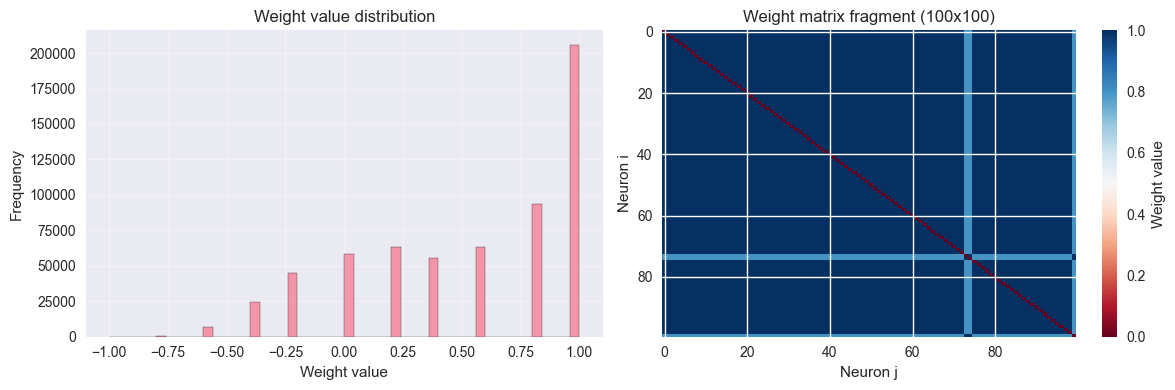

In [72]:
def analyze_weight_matrix():
    print(f"Weight matrix size: {hopfield.weights.shape}")
    print(f"Mean weight: {np.mean(hopfield.weights):.6f}")
    print(f"Weight standard deviation: {np.std(hopfield.weights):.6f}")
    print(f"Min/Max weight: {np.min(hopfield.weights):.6f} / {np.max(hopfield.weights):.6f}")
    
    is_symmetric = np.allclose(hopfield.weights, hopfield.weights.T)
    print(f"Symmetric matrix: {is_symmetric}")
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(hopfield.weights.flatten(), bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Weight value')
    plt.ylabel('Frequency')
    plt.title('Weight value distribution')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.imshow(hopfield.weights[:100, :100], cmap='RdBu', aspect='auto')
    plt.colorbar(label='Weight value')
    plt.title('Weight matrix fragment (100x100)')
    plt.xlabel('Neuron j')
    plt.ylabel('Neuron i')
    
    plt.tight_layout()
    plt.show()

analyze_weight_matrix()

In [73]:
def test_pattern_similarity():
    similar_indices = [np.where(y == 1)[0][0], np.where(y == 7)[0][0]]
    similar_patterns = X_binary[similar_indices]
    
    different_indices = [np.where(y == 0)[0][0], np.where(y == 8)[0][0]]
    different_patterns = X_binary[different_indices]
    
    for name, patterns in [("Similar (1,7)", similar_patterns), 
                          ("Different (0,8)", different_patterns)]:
        
        test_net = HopfieldNetwork(784)
        test_net.train(patterns)
        
        accuracies = []
        for pattern in patterns:
            noisy = add_noise(pattern, 0.15)
            recalled, _, _ = test_net.recall(noisy, method='async', max_iter=50)
            accuracies.append(np.mean(recalled == pattern))
        
        avg_accuracy = np.mean(accuracies)
        print(f"{name}: Average accuracy = {avg_accuracy:.1%}")

test_pattern_similarity()

Similar (1,7): Average accuracy = 100.0%
Different (0,8): Average accuracy = 100.0%


100%|█████████████████████████████████████████████| 9/9 [00:02<00:00,  4.43it/s]


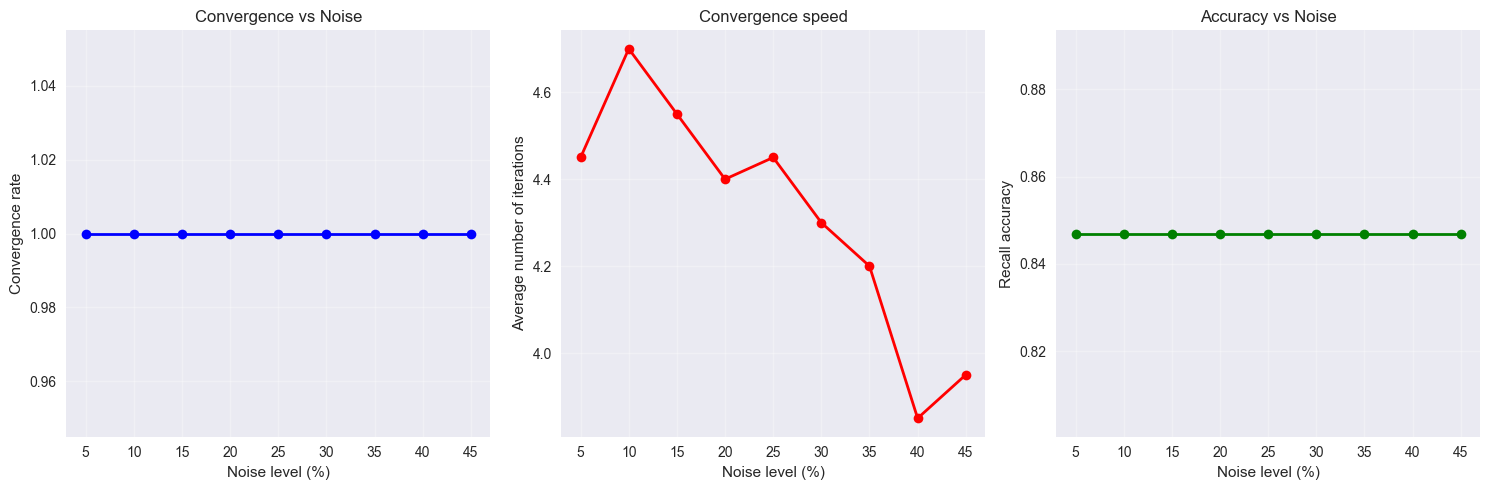

In [75]:
def analyze_convergence():
    pattern = selected_patterns[0]
    noise_levels = np.arange(0.05, 0.5, 0.05)
    
    convergence_rates = []
    avg_iterations = []
    final_accuracies = []
        
    for noise_level in tqdm(noise_levels):
        converged_count = 0
        total_iterations = 0
        total_accuracy = 0
        n_tests = 20
        
        for _ in range(n_tests):
            noisy = add_noise(pattern, noise_level)
            recalled, energy_hist, converged = hopfield.recall(
                noisy, method='async', max_iter=100
            )
            
            if converged:
                converged_count += 1
                total_iterations += len(energy_hist) - 1
            
            total_accuracy += np.mean(recalled == pattern)
        
        convergence_rate = converged_count / n_tests
        avg_iter = total_iterations / max(converged_count, 1)
        avg_accuracy = total_accuracy / n_tests
        
        convergence_rates.append(convergence_rate)
        avg_iterations.append(avg_iter)
        final_accuracies.append(avg_accuracy)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].plot(noise_levels * 100, convergence_rates, 'bo-', linewidth=2)
    axes[0].set_xlabel('Noise level (%)')
    axes[0].set_ylabel('Convergence rate')
    axes[0].set_title('Convergence vs Noise')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(noise_levels * 100, avg_iterations, 'ro-', linewidth=2)
    axes[1].set_xlabel('Noise level (%)')
    axes[1].set_ylabel('Average number of iterations')
    axes[1].set_title('Convergence speed')
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(noise_levels * 100, final_accuracies, 'go-', linewidth=2)
    axes[2].set_xlabel('Noise level (%)')
    axes[2].set_ylabel('Recall accuracy')
    axes[2].set_title('Accuracy vs Noise')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

analyze_convergence()